In [105]:
#  import libraries
import h5py
import os, sys
import zipfile
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt


# --- Configuration ---
sys.path.insert(0, '../../../config')
from _utility_imports import *

In [106]:
# Path to the ZIP file
# check if .zip file exists
# if not os.path.exists("results.zip"):
#     print("The file 'results.zip' does not exist.")
#     sys.exit()
    
# zip_file_path = "results.zip"
# # zip_file_path = "results_loc_joint.zip"
# output_folder = "results"

# # Unzip the file
# if os.path.exists(zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         # Create the output folder if it doesn't exist
#         if not os.path.exists(output_folder):
#             os.makedirs(output_folder)
#         zip_ref.extractall(output_folder)
#     print(f"Extracted '{zip_file_path}' to '{output_folder}'")
# else:
#     print(f"The file '{zip_file_path}' does not exist.")


Reading data from results/true-wrong-icepack.h5...
Dataset 'Lxy' extracted with shape (2,)
Dataset 'b_io' extracted with shape (2,)
Dataset 'ensemble_nurged_state' extracted with shape (1700, 101)
Dataset 'ensemble_true_state' extracted with shape (1700, 101)
Dataset 'nxy' extracted with shape (2,)
Dataset 'obs_index' extracted with shape (7,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 'run_mode' extracted with shape (1,)
Dataset 't' extracted with shape (101,)
Dataset 'w' extracted with shape (1700, 7)
Data extraction complete.
At h_indx = 0 profile 
(7,)


Text(0.5, 1.0, 'begining profile at h_indx = 0')

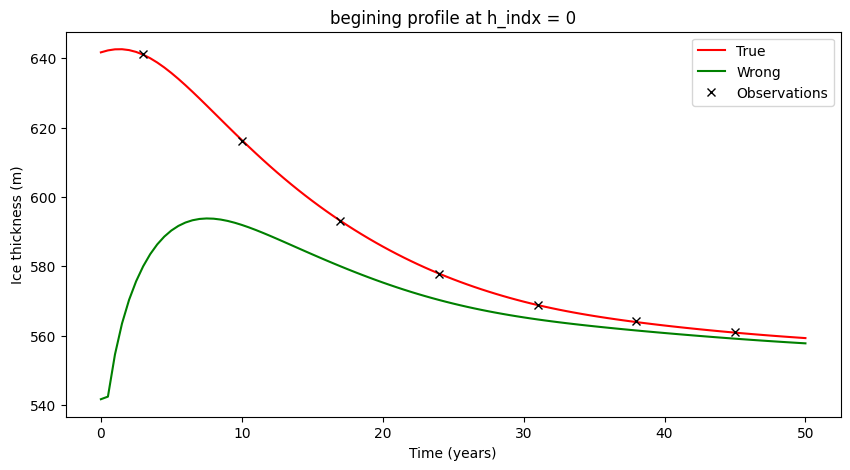

In [ ]:
results_dir = "results"
filter_type = "true-wrong"
# file_path = f"results/{filter_type}-icepack.h5"
file_path = f"{results_dir}/{filter_type}-icepack.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
ensemble_true_state = datasets_tw['ensemble_true_state']
ensemble_nurged_state = datasets_tw['ensemble_nurged_state']
w = datasets_tw['w']
ind_m = datasets_tw['obs_index']
tm_m = datasets_tw['obs_max_time'][0]
run_mode = datasets_tw['run_mode'][0]

nt = ensemble_true_state.shape[1]; num_steps = nt-1
ndim = ensemble_true_state.shape[0]
hdim = ndim//4 # [h,u,v,smb]

# plot the ensemble_true_state and ensemble_nurged_state
htrue = ensemble_true_state[:hdim,:]
hnurge = ensemble_nurged_state[:hdim,:]

# define profile flag
profile_flag = "middle" # begining, middle, end, random
# h_indx = 0 # first profile
# h_indx = htrue.shape[1]//2 # middle profile
# h_indx = htrue.shape[1]-1 # last profile
# h_indx = np.random.randint(htrue.shape[1])  # random profile
if profile_flag == "begining":
    h_indx = 0 # first profile
elif profile_flag == "middle":
    h_indx = htrue.shape[1]//2
elif profile_flag == "end":
    h_indx = htrue.shape[1]-1
elif profile_flag == "random":
    h_indx = np.random.randint(htrue.shape[1])

print(f"At h_indx = {h_indx} profile ")

h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]

plt.figure(figsize=(10,5))
plt.plot(t,h_true,'r',label='True')
plt.plot(t,h_nurged,'g',label='Wrong')
obs = w[h_indx,:]; print(obs.shape)
plt.plot(t[ind_m],obs,'kx',label="Observations")
plt.xlabel('Time (years)')
plt.ylabel('Ice thickness (m)')
plt.legend()
plt.title(f"{profile_flag} profile at h_indx = {h_indx}")

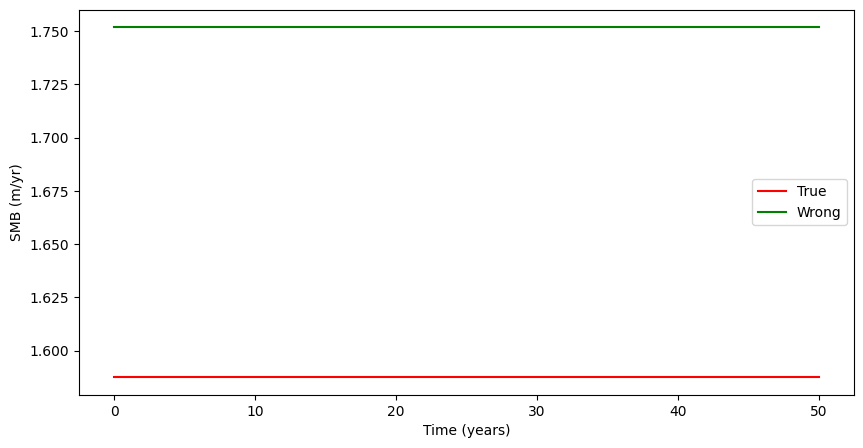

In [108]:
# extract smb
smbtrue = ensemble_true_state[3*hdim:,:]
smbnurged = ensemble_nurged_state[3*hdim:,:]

# plot the smbtrue
plt.figure(figsize=(10,5))
plt.plot(t,smbtrue[h_indx,:],'r',label='True')
plt.plot(t,smbnurged[h_indx,:],'g',label='Wrong')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.legend()

In [109]:
filter_type = "EnKF"
if run_mode != 0:
    file_path = f"{results_dir}/{filter_type}-icepack.h5"
    datasets = extract_datasets_from_h5(file_path)
    ensemble_vec_full = datasets["ensemble_vec_full"]
    ensemble_vec_mean = datasets["ensemble_vec_mean"] 
    ensemble_bg       = datasets["ensemble_bg"]
else:
    file_path = '_modelrun_datasets/ensemble_data.h5'
    import h5py
    with h5py.File(file_path, 'r') as f:
        ensemble_vec_full = f['ensemble'][:]
        ensemble_vec_mean = f['ensemble_mean'][:]
        ensemble_bg = None
    

In [110]:
from firedrake import *
import firedrake

Lx, Ly = datasets_tw["Lxy"][0], datasets_tw["Lxy"][1]
nx, ny = datasets_tw["nxy"][0], datasets_tw["nxy"][1]

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
x, y = firedrake.SpatialCoordinate(mesh)
b_in, b_out = datasets_tw["b_io"][0], datasets_tw["b_io"][1]
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

# form a rectangular mesh and get x, y coordinates
x, y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
print(nx, ny, Lx, Ly)

12 8 5000 1200


In [111]:
hdim

425

425


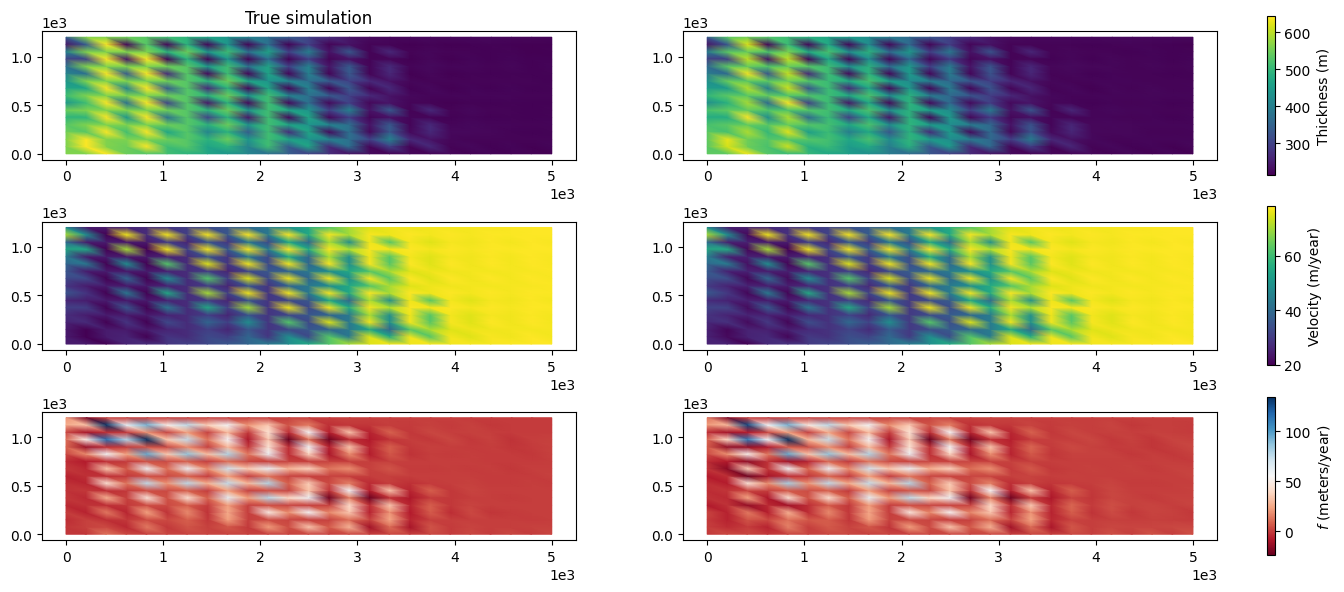

In [112]:
from firedrake import div
import copy
import icepack
import icepack.plot
fig, axes = icepack.plot.subplots(3,2, figsize=(16,7))
step = nt-1
hhtrue = firedrake.Function(Q)
print(hhtrue.dat.data.size)
uutrue = firedrake.Function(V)
hhtrue.dat.data[:] = copy.deepcopy(ensemble_true_state[:hdim,step])
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0])
fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation")

# ploting the velocity field
uutrue.dat.data[:,0] = copy.deepcopy(ensemble_true_state[hdim:2*hdim,step])
uutrue.dat.data[:,1] = copy.deepcopy(ensemble_true_state[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uutrue, axes=axes[1][0])
fig.colorbar(colors, ax=axes[1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# ploting the basal shear stress
f = firedrake.interpolate(div(hhtrue*uutrue), Q)
colors = firedrake.tripcolor(f, axes=axes[2][0], cmap="RdBu")
fig.colorbar(colors, ax=axes[2], fraction=0.012, pad=0.04, label=r"$f$ (meters/year)")

# axes[0][1].set_title("EnKF simulation")
# axes[0][1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")
hhenkf = firedrake.Function(Q)
uuenkf = firedrake.Function(V)
hhenkf.dat.data[:] = copy.deepcopy(ensemble_vec_mean[:hdim,step])
colors = firedrake.tripcolor(hhenkf, axes=axes[0][1])
# fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")


# ploting the velocity field
uuenkf.dat.data[:,0] = copy.deepcopy(ensemble_vec_mean[hdim:2*hdim,step])
uuenkf.dat.data[:,1] = copy.deepcopy(ensemble_vec_mean[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uuenkf, axes=axes[1][1])


# ploting the basal shear stress
f = firedrake.interpolate(div(hhenkf*uuenkf), Q)
colors = firedrake.tripcolor(f, axes=axes[2][1], cmap="RdBu")

Text(0, 0.5, 'thickness (m)')

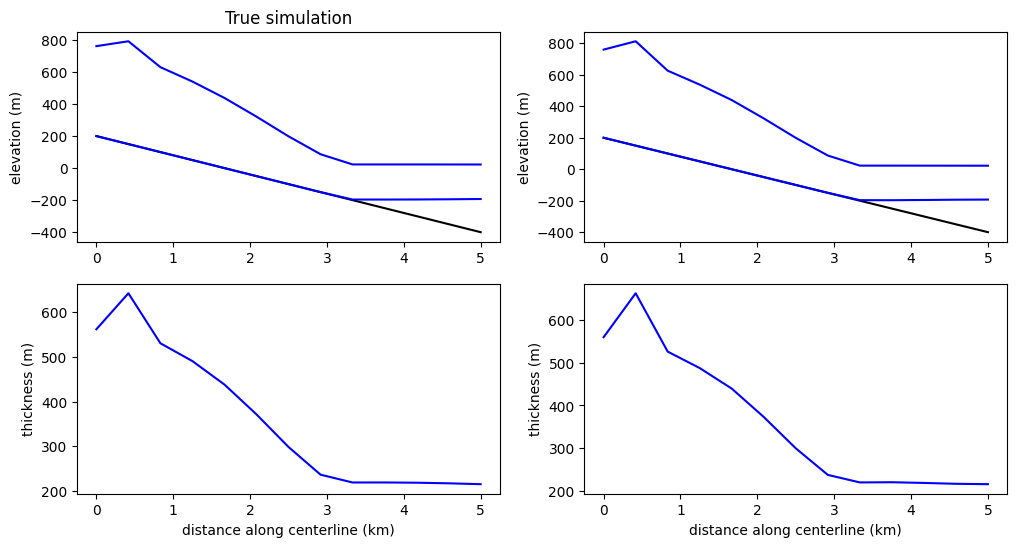

In [113]:
# we can draw some transects through the domain to see what the surface, bed, and ice base elevation look like

xs = np.array([(Lx * k /nx, 0) for k in range(nx + 1)])
s = icepack.compute_surface(thickness = hhtrue, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhtrue.at(xs, tolerance=1e-10))

fig, axes = plt.subplots(2,2, figsize=(12, 6))
axes[0,0].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,0].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,0].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,0].set_xlabel("distance along centerline (km)")
axes[0,0].set_ylabel("elevation (m)")
axes[0,0].set_title("True simulation")

axes[1,0].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,0].set_xlabel("distance along centerline (km)")
axes[1,0].set_ylabel("thickness (m)")


s = icepack.compute_surface(thickness = hhenkf, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhenkf.at(xs, tolerance=1e-10))

axes[0,1].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,1].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,1].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,1].set_xlabel("distance along centerline (km)")
axes[0,1].set_ylabel("elevation (m)")
# axes[0,1].set_title("DEnKF simulation")
# axes[0,1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")

axes[1,1].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,1].set_xlabel("distance along centerline (km)")
axes[1,1].set_ylabel("thickness (m)")

Text(0.5, 1.0, 'begining profile at u_indx = 425 and v_indx = 850')

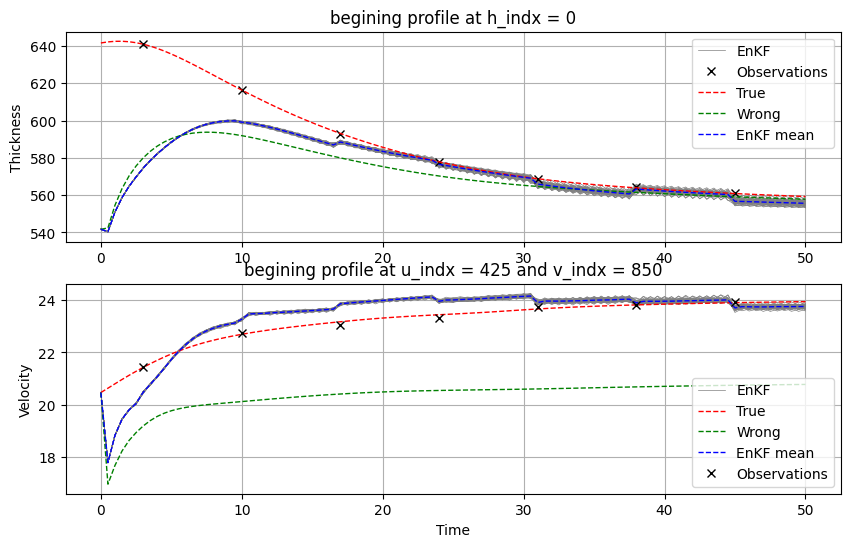

In [114]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

# h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])
obs_h = w[h_indx,:]


# plot the h middle profile
# h_indx = hens.shape[1]//2
hens = ensemble_vec_mean[:hdim,:]
h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = ensemble_vec_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
Nens = ensemble_vec_full.shape[1]
for ens in range(Nens):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t[ind_m],obs_h,'kx',label="Observations")

ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_nurged,'--g',label='Wrong',linewidth=1)
ax[0].plot(t,h_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
# ax[0].set_ylim([350, 500])
# ax[0].set_xlim([1, 250])
# ax[0].set_xlabel('Time')
ax[0].grid()
ax[0].set_ylabel('Thickness')
ax[0].set_title(f"{profile_flag} profile at h_indx = {h_indx}")

# plot the u middle profile
# u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
# v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
# uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
obs_u = w[u_indx,:]
obs_v = w[v_indx,:]
uobs = np.sqrt(obs_u**2 + obs_v**2)
u_true = ensemble_true_state[u_indx,:]
v_true = ensemble_true_state[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_nurge = ensemble_nurged_state[u_indx,:]
v_nurge = ensemble_nurged_state[v_indx,:]
unurge = np.sqrt(u_nurge**2 + v_nurge**2)
u_ens_mean = ensemble_vec_mean[u_indx,:]
v_ens_mean = ensemble_vec_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = ensemble_vec_full[u_indx,:,:].T
v_ens_mem  = ensemble_vec_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(Nens):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,unurge,'--g',label='Wrong',linewidth=1)
ax[1].plot(t,uens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
ax[1].plot(t[ind_m],uobs,'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].grid()
ax[1].set_title(f"{profile_flag} profile at u_indx = {u_indx} and v_indx = {v_indx}")


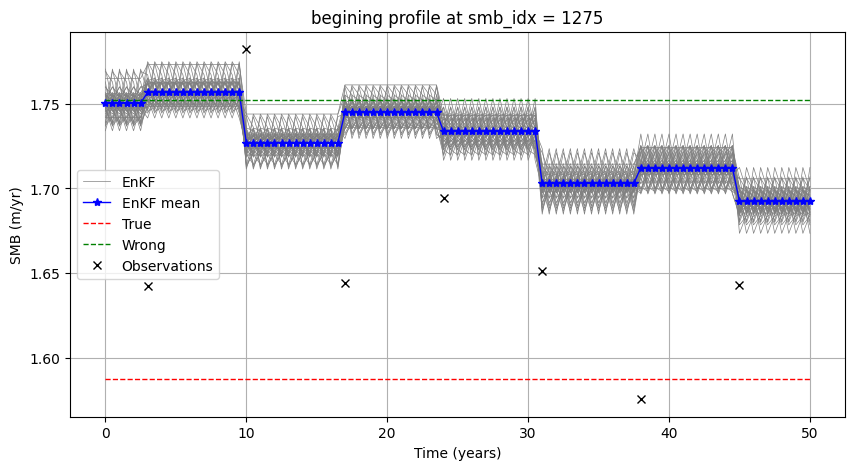

In [115]:
# plot the smb middle profile
smb_idx = 3*hdim + h_indx
smbtrue = ensemble_true_state[smb_idx,:]
smb_nurged = ensemble_nurged_state[smb_idx,:]
smbs_ens_mean = ensemble_vec_mean[smb_idx,:]
smb_ens = ensemble_vec_full[smb_idx,:,:].T
smb_obs = w[smb_idx,:]
plt.figure(figsize=(10,5))
for ens in range(Nens):
    plt.plot(t,smb_ens[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")
plt.plot(t,smbs_ens_mean,'-*b',label=f"{filter_type} mean",linewidth=1)
plt.plot(t,smbtrue,'--r',label='True',linewidth=1)
plt.plot(t,smb_nurged,'--g',label='Wrong',linewidth=1)
plt.plot(t[ind_m],smb_obs,'kx',label='Observations')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.title(f"{profile_flag} profile at smb_idx = {smb_idx}")
plt.grid()
plt.legend()


In [116]:

dim_list = np.array([2,4,6,8,10])  #list of hdim(ordered) or add nd with id
# dim_list = np.array([4,4,4,4,4])
rank = 1      # rank of the current processor
dim = dim_list[rank] # get the hdim of the current processor
offsets = np.cumsum(np.insert(dim_list, 0, 0))  # Insert 0 at the beginning for the first offset
start_idx = offsets[rank] # get the start index of the current processor
hdim = 30
h_start = 0
u_start = h_start + hdim
v_start = u_start + hdim
smb_start = v_start + hdim
# vec = [h,u,v,smb], h ~ [0:30] u ~ [30:60] v ~ [60:90] smb ~ [90:120]
vec = np.arange(120)
h = vec[start_idx:start_idx+dim] 
u = vec[u_start+start_idx:u_start+start_idx+dim]
v = vec[v_start+start_idx:v_start+start_idx+dim]
smb = vec[smb_start+start_idx:smb_start+start_idx+dim]
print(f"rank = {rank}, h = {h}, u = {u}, v = {v}, smb = {smb}")

def get_index(vec, vec_inputs, hdim, dim_list,  comm):
    """get the index of the variables in the vector
        - vec: the vector to be distributed
        - vec_inputs: list of the input variables strings: eg. ['h','u','v','smb']
        - hdim: size of each variable in vec_inputs
        - dim_list: list of the sizes of each rank; ordered through the ranks using MPI_gather on root and the broadcast
        - comm: MPI communicator containing the rank and size of the processors
    """
    rank = comm.Get_rank() # get the rank of the current processor
    dim = dim_list[rank] # get the hdim of the current processor
    offsets = np.cumsum(np.insert(dim_list, 0, 0))  # Insert 0 at the beginning for the first offset
    start_idx = offsets[rank] # get the start index of the current processor
    h_start = 0
    u_start = h_start + hdim
    v_start = u_start + hdim
    smb_start = v_start + hdim

    # given parameters and variables
    # TODO: automate this process by getting the variables from the vec_inputs
    h = vec[start_idx:start_idx+dim] 
    u = vec[u_start+start_idx:u_start+start_idx+dim]
    v = vec[v_start+start_idx:v_start+start_idx+dim]
    smb = vec[smb_start+start_idx:smb_start+start_idx+dim]
    return h, u, v, smb

rank = 1, h = [2 3 4 5], u = [32 33 34 35], v = [62 63 64 65], smb = [92 93 94 95]


In [117]:
import numpy as np
from mpi4py import MPI

def get_index_(vec, vec_inputs, **kwargs):
    """
    Get the index of the variables in the vector dynamically.

    Parameters:
        - vec: The vector to be distributed
        - vec_inputs: List of input variable names, e.g., ['h', 'u', 'v', 'smb']
        - hdim: Size of each variable in vec_inputs
        - dim_list: List of sizes of each rank; ordered through the ranks using MPI_gather on root and broadcast
        - comm: MPI communicator containing the rank and size of the processors

    Returns:
        - A dictionary where keys are variable names and values are their respective slices from `vec`
    """
    comm = kwargs.get("comm", None)
    dim_list = kwargs.get("dim_list", None)
    hdim = vec.shape[0]//len(vec_inputs)  # Compute the size of each variable in vec_inputs

    if comm is None:
        # non mpi case
        rank = 0
        dim = dim_list[rank]
        offsets = [0] # no offsets needed
    else:
        # mpi case
        # rank = comm.Get_rank()  # Get the rank of the current processor
        rank = 3
        dim = dim_list[rank]  # Get the hdim of the current processor
        offsets = np.cumsum(np.insert(dim_list, 0, 0))  # Compute offsets per processor

    start_idx = offsets[rank]  # Get the start index of the current processor

    # Dynamically determine start indices for each variable
    var_indices = {}
    var_start = 0  # Initial start index

    for var in vec_inputs:
        var_indices[var] = vec[var_start + start_idx: var_start + start_idx + dim]
        var_start += hdim  # Move to the next variable slice

    return var_indices

In [118]:
import numpy as np
from mpi4py import MPI

def get_index(vec, vec_inputs, **kwargs):
    """
    Get the index of the variables in the vector dynamically.

    Parameters:
        - vec: The vector to be distributed
        - vec_inputs: List of input variable names, e.g., ['h', 'u', 'v', 'smb']
        - hdim: Size of each variable in vec_inputs
        - dim_list: List of sizes of each rank; ordered through the ranks using MPI_gather on root and broadcast
        - comm: MPI communicator containing the rank and size of the processors

    Returns:
        - var_indices: Dictionary where keys are variable names and values are their respective slices from `vec`
        - index_map: Dictionary where keys are variable names and values are the indices corresponding to their slices
    """
    comm = kwargs.get("comm", None)
    dim_list = kwargs.get("dim_list", None)
    hdim = vec.shape[0] // len(vec_inputs)  # Compute the size of each variable in vec_inputs

    if comm is None:
        # Non-MPI case
        rank = 0
        dim = dim_list[rank]
        offsets = [0]  # No offsets needed
    else:
        # MPI case
        rank = comm.Get_rank()  # Get the rank of the current processor
        dim = dim_list[rank]  # Get the hdim of the current processor
        offsets = np.cumsum(np.insert(dim_list, 0, 0))  # Compute offsets per processor

    start_idx = offsets[rank]  # Get the start index of the current processor

    # Dynamically determine start indices for each variable
    var_indices = {}
    index_map = {}
    var_start = 0  # Initial start index

    for var in vec_inputs:
        start = var_start + start_idx
        end = start + dim
        var_indices[var] = vec[start:end]
        index_map[var] = np.arange(start, end)  # Store index range for easy fetching
        var_start += hdim  # Move to the next variable slice

    return var_indices, index_map


In [119]:
vec = np.linspace(0, 120, 40)
vec_inputs = ['h','u','v','smb']
dim_list = np.array([2,4,6,8,10])
kwargs = {"comm": 0, "dim_list": dim_list}
indx = get_index_(vec, vec_inputs, **kwargs)
indx["h"]

array([36.92307692, 40.        , 43.07692308, 46.15384615, 49.23076923,
       52.30769231, 55.38461538, 58.46153846])

In [120]:
indx["v"]

array([ 98.46153846, 101.53846154, 104.61538462, 107.69230769,
       110.76923077, 113.84615385, 116.92307692, 120.        ])

In [121]:
import h5py
with h5py.File('_modelrun_datasets/ensemble_data.h5', 'r') as f:
    ensemble_data = f['ensemble'][:]
    ens_mean = f['ensemble_mean'][:]
    # ensemble_data = ensemble_data[:]
    # ens = ensemble_data[:,0,1]
    # for ens in range(3):
        # print(ensemble_data[:,ens].shape)
    # ens = ensemble_data[:,0].reshape(-1,1)
    

In [122]:
ensemble_data[:,0,1]


array([540.23123526, 570.76699703, 545.29323583, ...,  -0.84210766,
        -0.9707581 ,  -0.97204091], shape=(1700,))

In [123]:
ens_mean

array([[541.67617669, 540.38574088, 550.93965843, ..., 555.84441345,
        555.73490968, 555.61182489],
       [552.35577829, 570.86798105, 589.71705493, ..., 644.31601819,
        644.25610417, 644.18578532],
       [546.3066163 , 545.27984249, 554.45332033, ..., 562.99873665,
        562.74055982, 562.51622612],
       ...,
       [ -0.84392096,  -0.84392096,  -0.84392096, ...,  -0.72999259,
         -0.72999259,  -0.72999259],
       [ -0.96429302,  -0.96429302,  -0.96429302, ...,  -0.89717599,
         -0.89717599,  -0.89717599],
       [ -0.96355009,  -0.96355009,  -0.96355009, ...,  -0.83321304,
         -0.83321304,  -0.83321304]], shape=(1700, 101))